# Hero Run for Training ConvTransformer  (32x3x4)

So not sure how mpi will be calling the models, but potentially x72 models. I wanted to have an ensamble of 3 models to calc the average output. So need x216 models, at 200 MB is 43.2 GB. Further investigation is needed.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torch.amp import autocast
from torch.amp import GradScaler

import h5py as h5

import matplotlib.pyplot as plt

from os.path import join

We are going to do hybrid heterogenious computing, so assert GPU is available

In [2]:
assert torch.cuda.is_available(), 'CUDA is not available.'
device = torch.device('cuda')
dtype = torch.float64

## Transformer Based Model

In [3]:
class DepthWiseConv1d(nn.Module):
    def __init__(self, out_dim: int, input_shape: list[int] = [32, 3, 4]):
        super(DepthWiseConv1d, self).__init__()
        '''
        Perform a depthwise 1D convolution over the last dimension (4) of the input tensor, 
        followed by a pointwise convolution to output a tensor with shape (-1, 33*3, out_dim).
        Args:
            - out_dim (int): Number of output features
            - input_shape (list): Shape of the input tensor, default is [33,3,4] 
        '''
        self.out_dim = out_dim

        # Calculate the number of input channels for the convolution
        in_channels = input_shape[0] * input_shape[1]  # 33 * 3

        # Depthwise 1D convolution on the last dimension (4)
        self.depthwise = nn.Conv1d(
            in_channels=in_channels, 
            out_channels=in_channels,  # Depthwise keeps the number of channels the same
            kernel_size=input_shape[2],  # 1D convolution kernel size
            groups=in_channels  # Depthwise convolution
        )

        # Pointwise convolution to adjust to the desired output dimension
        self.pointwise = nn.Conv1d(
            in_channels=in_channels,  # 99 channels from the depthwise output
            out_channels=in_channels,  # Keep the same number of channels
            kernel_size=1  # Pointwise convolution
        )

        # Linear layer to map to the desired output dimension
        self.linear = nn.Linear(in_channels, self.out_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Reshape input to [batch_size, in_channels, 4]
        x = x.view(x.size(0), -1, x.size(-1))  # Adjust to [batch_size, 99, 4]

        # Apply depthwise convolution
        x = self.depthwise(x)

        # Apply pointwise convolution
        x = self.pointwise(x)

        x = x.permute(0, 2, 1)  # Permute to shape [batch_size, sequence_length, in_channels]
        x = self.linear(x)
        
        return x


In [4]:
class InnerTransformer(nn.Module):
    def __init__(self, input_dim:int, output_dim:int, num_layers:int=2):
        super(InnerTransformer, self).__init__()
        '''
        Args:
            - input_dim (int): Number of input features
            - output_dim (int): Number of output features
            - num_layers (int): Number of transformer layers, default is 1
        '''
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        # Build transformer layers
        self.layers = nn.ModuleList([nn.TransformerEncoderLayer(d_model=self.input_dim, nhead=1) for _ in range(self.num_layers)]) # Make it simple for now

        # Linear layer to output
        self.linear = nn.Linear(self.input_dim, self.output_dim)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x

In [5]:
class ConvTrans(nn.Module):
    def __init__(self, input_shape:list[int]=[32,3,4], inner_shape:int=int(32*2), out_dim:int=int(2*4), num_layers:int=2):
        super(ConvTrans, self).__init__()
        '''
        Build a DepthWiseConv1d model followed by a Transformer model followed by an output layer(tbd)
        Args:
            - input_shape (list): Shape of the input tensor, default is [33,3,4] (32 cells, 3 features, 1x4 grid, followed by spacial cell). 
            - inner_shape (int): Number of features to pass to the transformer, default is 32*2
            - out_dim (int): Number of output features, default is 32*2*4 (32 cells, 2 features, 1x4 grid)
            - num_layers (int): Number of transformer layers, default is 2
        '''
        self.depthwise = DepthWiseConv1d(out_dim=inner_shape, input_shape=input_shape)
        self.transformer = InnerTransformer(input_dim=inner_shape, output_dim=out_dim, num_layers=num_layers)
        self.output_cov = nn.Conv1d(in_channels=inner_shape, out_channels=32, kernel_size=1)
        self.output_linear = nn.Linear(32, 32*out_dim)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.depthwise(x)
        x = self.transformer(x)
        x = x.permute(0, 2, 1)
        x = self.output_cov(x)
        x = x.squeeze()
        x = self.output_linear(x)
        x = x.view(-1, 32, 2, 4) # Maybe make args??? IDK
        return x

## Data Loading

Data was pre partitioned into training and test dataset

In [6]:
train_name = join('/home/dan/Documents/MSc/weather_data/', 'train_data.h5')
test_name = join('/home/dan/Documents/MSc/weather_data/', 'test_data.h5')

Method to load hdf5 file of the processed weather data

In [7]:
def load_hdf5(filename:str):
    '''
    Load data from an HDF5 file and return a list of dictionaries.
    Inputs:
        - filename (str): Path to the HDF5 file.
    Outputs:
        - data (list): List of dictionaries, where each dictionary represents an entry in the original list.
    '''
    data = []  # List to hold dictionaries
    with h5.File(filename, 'r') as f:
        # Iterate through groups (each representing an entry in the original list)
        for group_name in f:
            group = f[group_name]
            # Reconstruct dictionary from datasets and attributes
            entry = {
                # Attributes (metadata)
                'day': group.attrs['day'],
                'region': group.attrs['region'],
                'time': group.attrs['time'],

                # groups (numpy arrays)
                'landmass': group['landmass'][...],  # Use [...] to read the full dataset
                'x': group['x'][...],
                'y': group['y'][...],
            }
            data.append(entry)
    return data

Generate stacks to train

In [8]:
def stack_data(data:list[dict], key:str) -> torch.Tensor:
    return torch.stack([torch.tensor(entry[key]) for entry in data])


def generate_stacks(data:list[dict]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    '''
    Create a PyTorch DataLoader from the data.
    Inputs:
        - data (list): List of dictionaries, where each dictionary represents an entry in the original list.
    Outputs:
        - landmass (torch.Tensor): Tensor of landmass data.
        - x (torch.Tensor): Tensor of x-coordinate data.
        - y (torch.Tensor): Tensor of y-coordinate data.
    '''
    landmass = stack_data(data, 'landmass')
    landmass = landmass.view(-1, 3, 4)

    x = stack_data(data, 'x')
    x = x.transpose(2, 1)
    x = x.view(-1, 32, 3, 4)

    y = stack_data(data, 'y')
    y = y.transpose(2, 1)
    y = y.view(-1, 32, 2, 4)
    
    return (landmass, x, y)


class weather_dataset(Dataset):
    '''
    PyTorch Dataset class for weather data.
    '''
    def __init__(self, data:list[dict]):
        self.landmass, self.x, self.y = generate_stacks(data)
        self.length = len(self.landmass)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

Partition training data into train and validation sets.

In [9]:
def get_dataloaders(fname:str, batch_size:int, split:int) -> tuple[DataLoader, DataLoader]:
    '''
    Create PyTorch DataLoader objects for training and validation data.
    Inputs:
        - fname (str): Path to the HDF5 file.
        - batch_size (int): Batch size for the DataLoader objects.
        - split (float): Fraction of the data to use for training.     
    Outputs:
        - train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        - test_loader (torch.utils.data.DataLoader): DataLoader for test data.
    '''
    # Load data and create tensor 
    data = load_hdf5(fname)
    dataset = weather_dataset(data)
    
    train_size = int(split * len(dataset))
    val_size = len(dataset) - train_size
    
    # Split data into training and validation sets
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    # Create DataLoader objects
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    return train_loader, test_loader

Only Normalize the x/y data, not the landmass, on train_loader.dataset.*

## Model Block

Want to have normalization layer (x) -> reshape -> NN -> reshape - > denorm layer (y). 

In [10]:
class NormalizationLayer(nn.Module):
    def __init__(self, data: torch.Tensor):
        super(NormalizationLayer, self).__init__()

        # Compute mean and std along the batch_size, x1, and x2 dimensions
        self.mean = data.mean(dim=(0, 1), keepdim=True).to(device, dtype=dtype) 
        self.std = data.std(dim=(0, 1), keepdim=True).to(device, dtype=dtype) 

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        # Normalize the data
        normalized_data = (x - self.mean) / (self.std + 1e-9)  # Add a small constant to avoid division by zero
        return normalized_data

In [11]:
class DenormalizationLayer(nn.Module):
    def __init__(self, data: torch.Tensor):
        super(DenormalizationLayer, self).__init__()

        # Compute mean and std along the batch_size, x1, and x2 dimensions
        self.mean = data.mean(dim=(0, 1), keepdim=True).to(device, dtype=dtype)  
        self.std = data.std(dim=(0, 1), keepdim=True).to(device, dtype=dtype) 

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        # Denormalize the data
        denormalized_data = x * (self.std + 1e-9) + self.mean
        return denormalized_data

In [12]:
class ReshapeLayer(nn.Module):
    def __init__(self):
        super(ReshapeLayer, self).__init__()

    def reshape_x(self, l: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        l = l.unsqueeze(1)
        x = torch.cat((l, x), 1)
        return x

In [25]:
class CompleteModel(nn.Module):
    def __init__(self, norm_layer:NormalizationLayer, neural_network:ConvTrans, denorm_layer:DenormalizationLayer):
        super(CompleteModel, self).__init__()
        self.norm_layer = norm_layer
        # self.reshape_layer = reshape_layer 
        self.neural_network = neural_network
        self.denorm_layer = denorm_layer

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.norm_layer(x)
        # x = self.reshape_layer.reshape_x(l, x)

        x = self.neural_network(x)
        x = self.denorm_layer(x)
        return x

Only Norm/Denorm x and y

In [26]:
def make_model(loader) -> CompleteModel:
    norm_layer = NormalizationLayer(loader.dataset.dataset.x)
    denorm_layer = DenormalizationLayer(loader.dataset.dataset.y)
    # reshape_layer = ReshapeLayer().to(device, dtype=dtype) 

    model = ConvTrans().to(device, dtype=dtype) 

    network = CompleteModel(norm_layer, model, denorm_layer).to(device, dtype=dtype) 
    return network

## Training Loop 

Define training loop, use mixed percision training

In [22]:
def train(model:nn.Module, dl:torch.utils.data.DataLoader, optim:torch.optim, loss:nn.Module) -> float:
    model.train()
    total_loss = .0
    scaler = GradScaler()

    for _, (x, y) in enumerate(dl):
        x = x.to(device, dtype=dtype) 
        y = y.to(device, dtype=dtype) 

        optim.zero_grad()
        with autocast(device_type='cuda', dtype=torch.float16):
            y_pred = model(x)
            l = loss(y_pred, y)
            total_loss += l.item()

        # Preform backpass
        scaler.scale(l).backward()
        scaler.step(optim)
        scaler.update()
    
    return total_loss / len(dl)

Eval Loop

In [23]:
def eval(model:nn.Module, dl:torch.utils.data.DataLoader, loss:nn.Module) -> float:
    model.eval()
    total_loss = .0

    for _, (x, y) in enumerate(dl):
        x = x.to(device, dtype=dtype) 
        y = y.to(device, dtype=dtype)

        # Forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            y_pred = model(x)
            l = loss(y_pred, y)
            total_loss += l.item()

    return total_loss / len(dl)

## Training

In [27]:
folds = 3
models = {}

test_ds = weather_dataset(load_hdf5(test_name)) 
test_loader = DataLoader(test_ds, batch_size=256, shuffle=True, num_workers=8, pin_memory=True)

for i in range(folds):
    train_loader, val_loader = get_dataloaders(train_name, 256, 0.6)

    loss_fn = nn.MSELoss()
    model = make_model(train_loader) 
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Early Stopping 
    eval_loss = -1*float('inf') 
    train_loss  = float('inf') 
    j = 0
    print(f'Fold {i+1}')
    while train_loss > eval_loss:
        prev_eval_loss = eval_loss
        train_loss = train(model, train_loader, optimizer, loss_fn)
        eval_loss = eval(model, val_loader, loss_fn)
        print(f'\tEpoch {j} - Eval Loss: {eval_loss}')
        
        if abs(eval_loss - prev_eval_loss) < 0.005:
            print(f'\tEarly stopping at epoch {j} due to minimal change in eval loss')
            break
        j += 1

    # Test Loss
    test_loss = eval(model, test_loader, loss_fn)
    print(f'Fold {i+1} - Test Loss: {test_loss}')

    # Save Model
    model.eval()
    models[i] = model


Fold 1
	Epoch 0 - Eval Loss: 0.3672119661285955
	Epoch 1 - Eval Loss: 0.25977509426089884
	Epoch 2 - Eval Loss: 0.22033779081368654
	Epoch 3 - Eval Loss: 0.22895411449863112
Fold 1 - Test Loss: 0.251239200975143
Fold 2
	Epoch 0 - Eval Loss: 0.32372583690345497
	Epoch 1 - Eval Loss: 0.2472596053072115
	Epoch 2 - Eval Loss: 0.21416444969246154
Fold 2 - Test Loss: 0.22045536236230504
Fold 3
	Epoch 0 - Eval Loss: 0.3552685331509655
	Epoch 1 - Eval Loss: 0.2514262317899228
	Epoch 2 - Eval Loss: 0.20576691274898634
	Epoch 3 - Eval Loss: 0.18438203735252198
	Epoch 4 - Eval Loss: 0.18506597005519254
	Early stopping at epoch 4 due to minimal change in eval loss
Fold 3 - Test Loss: 0.2088931852637853


## Plotting

### Plot Single Column

In [28]:
def get_cell_data(t:torch.tensor) -> torch.tensor:
    t = t.view(-1, 32, 2, 2, 2)
    # T and QV are the 2 STD channels with a 2x2 grid
    # We want to get the top left cell for both channels
    p = t[:,:,:,0,0]
    p = p.view(-1, 32, 2)
    return p

In [29]:
def plot_column(data_dict:dict, idx:int):
    if idx not in {0,1}:
        raise ValueError('idx must be 0 or 1')
    title = 'Temp' if idx == 0 else 'QV'

    # Get the data for the 1st column (were just trying to determin if we want to park model for now)
    data = []
    for _,v in data_dict.items():
        data.append(v[0][0,:,idx])

    #print(data[0][:,0])
    data = torch.stack(data)
    #print(data[0,:,0])

    # Calculate Mean and STD
    mean = (data.mean(dim=0)).cpu().numpy()
    std = (data.std(dim=0)).cpu().numpy()

    # Get Real Values
    real = (data_dict[0][1][0,:,idx]).cpu().numpy()

    # Plot
    # Plotting
    plt.figure(figsize=(10, 6))
    x = range(len(mean))
            
    plt.plot(x, real, label='True Value', color='blue', linestyle='None', marker='o')
    plt.plot(x, mean, label='Mean Prediction', color='red', linestyle='--')
    plt.fill_between(x, mean - std, mean + std, color='gray', alpha=0.2, label='Prediction Std Dev')

    plt.title(f'{title} Predictions vs True Values')
    plt.xlabel('Level')
    plt.ylabel(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [30]:
batch_data = next(iter(test_loader))
x, y = batch_data
# l = l.cuda()
x = x.cuda()
y = y.cuda()

In [31]:
model_preds = {}
for i, model in models.items():
    with torch.no_grad():
        y_hat = model(x)
        model_preds[i] = (y_hat, y)

In [32]:
plot_values = {}
for k,v in model_preds.items():
    plot_values[k] = (get_cell_data(v[0]), get_cell_data(v[1]))

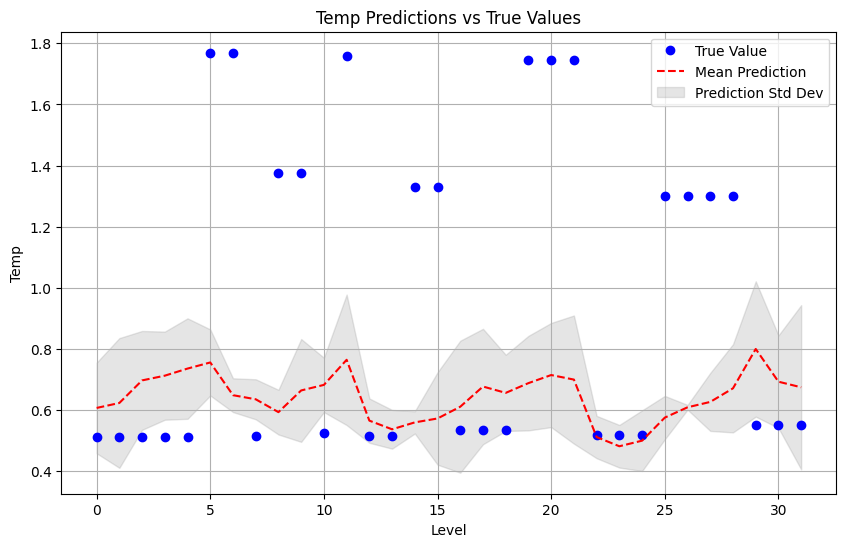

In [33]:
plot_column(plot_values, 0)

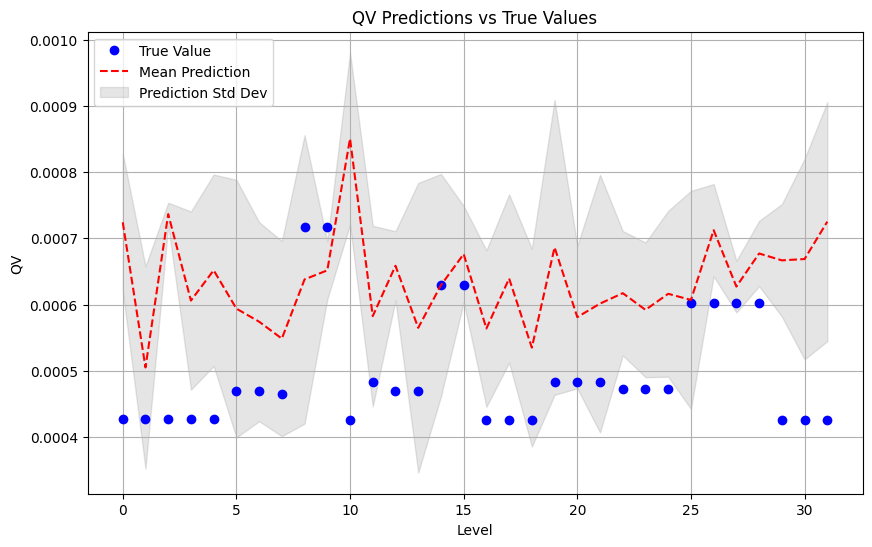

In [34]:
plot_column(plot_values, 1)

### Plot Single Cell

In [35]:
def slice_column(data, col):
    s = data[:,col,:,0] # Slice column pull 1st cell for now, make random later
    s = s.view(-1, 2)
    return s

In [36]:
def plot_cell(data_dict:dict, cell:int, idx:int):
    if idx not in {0,1}:
        raise ValueError('idx must be 0 or 1')
    title = 'Temp' if idx == 0 else 'QV'

    # Get the data for the 1st column (were just trying to determin if we want to park model for now)
    data = []
    for _,v in data_dict.items():
        data.append(v[0][:,idx])

    #print(data[0][0])
    data = torch.stack(data)
    #print(data[0,0])

    # Calculate Mean and STD
    mean = (data.mean(dim=0)).cpu().numpy()
    std = (data.std(dim=0)).cpu().numpy()

    # Get Real Values
    real = (data_dict[0][1][:,idx]).cpu().numpy()

    # Plotting
    plt.figure(figsize=(10, 6))
            
    # Plot the real values on the x-axis and the mean values on the y-axis
    plt.errorbar(real, mean, yerr=std, fmt='o', color='b', label='Mean Prediction with Std Dev')

    # Get the limits of the x-axis
    x_start, x_end = plt.xlim()

    # Add a line of slope 1
    plt.plot([x_start, x_end], [x_start, x_end], color='green', linestyle='-', label='Line of slope 1')


    plt.title(f'{title} Predictions vs True Values, Level {cell}')
    plt.xlabel('Real Value')
    plt.ylabel('Mean Prediction')
    plt.legend()
    plt.grid(True)

In [37]:
plot_values_cell_0 = {}
for k,v in model_preds.items():
    plot_values_cell_0[k] = (slice_column(v[0], 0), slice_column(v[1], 0))

In [38]:
plot_values_cell_0 = {}
for k,v in model_preds.items():
    plot_values_cell_0[k] = (slice_column(v[0], 0), slice_column(v[1], 0))

/tmp/ipykernel_711289/1445899909.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


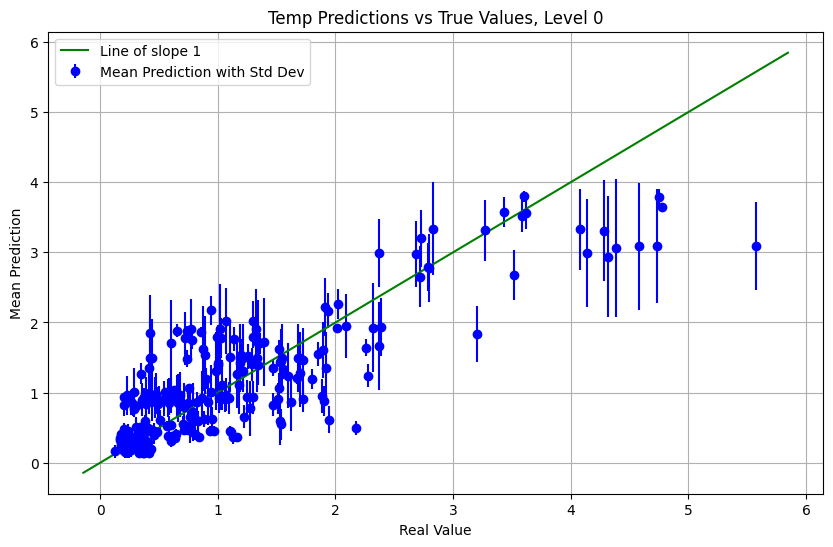

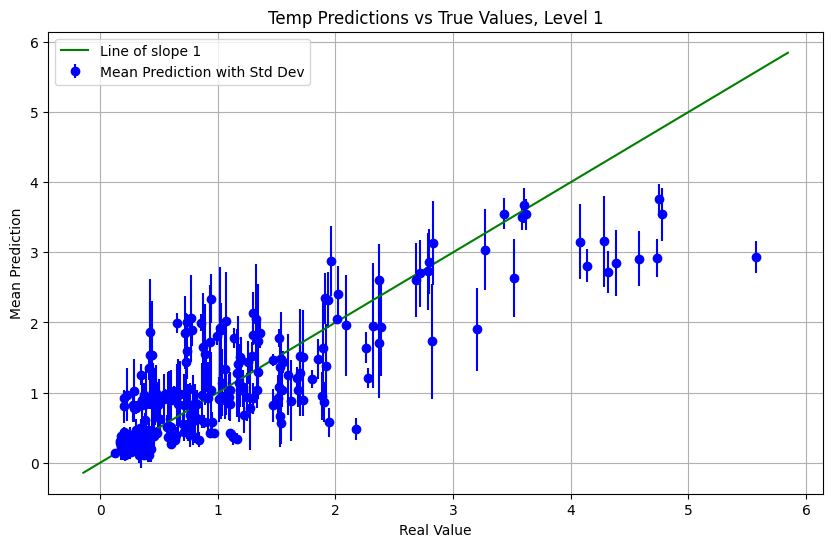

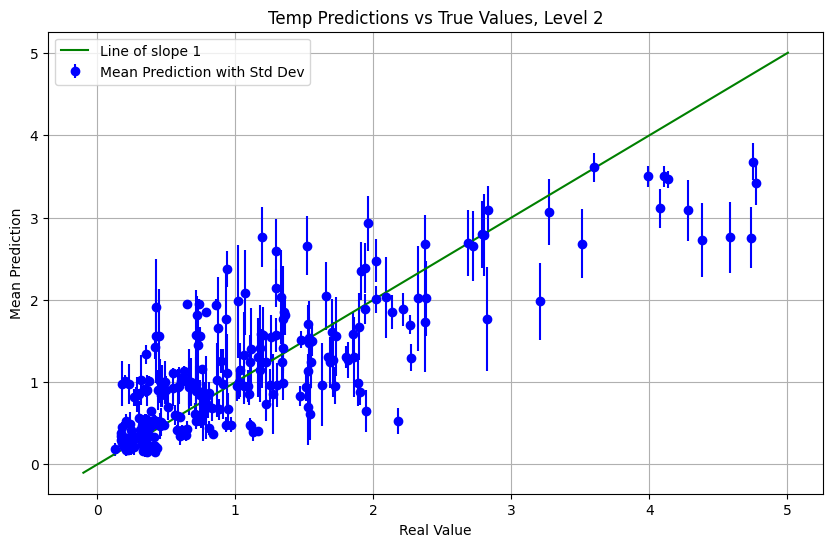

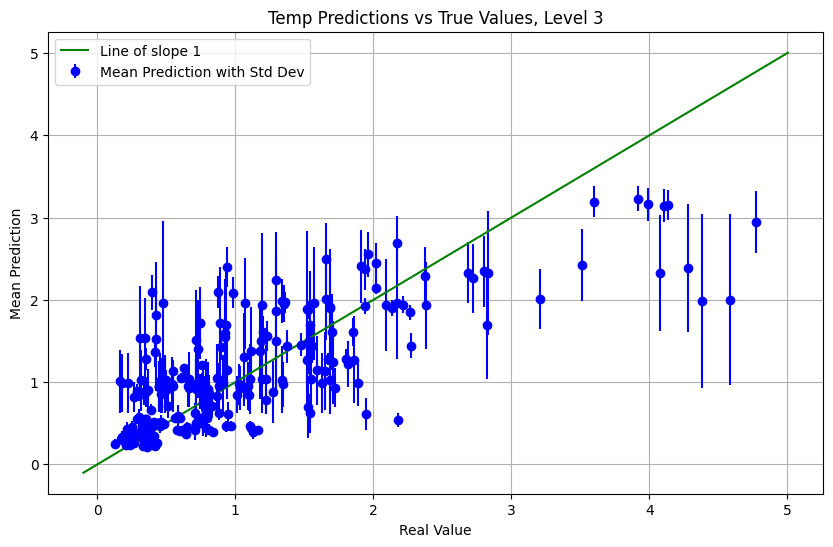

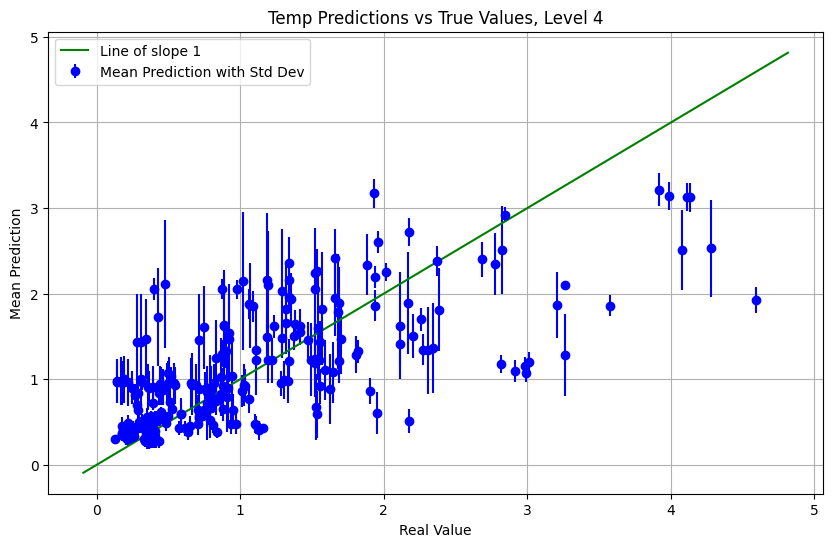

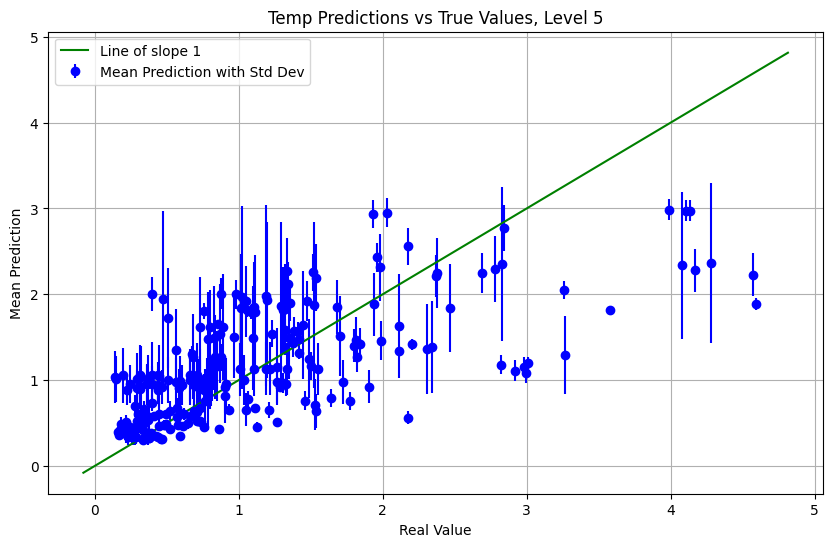

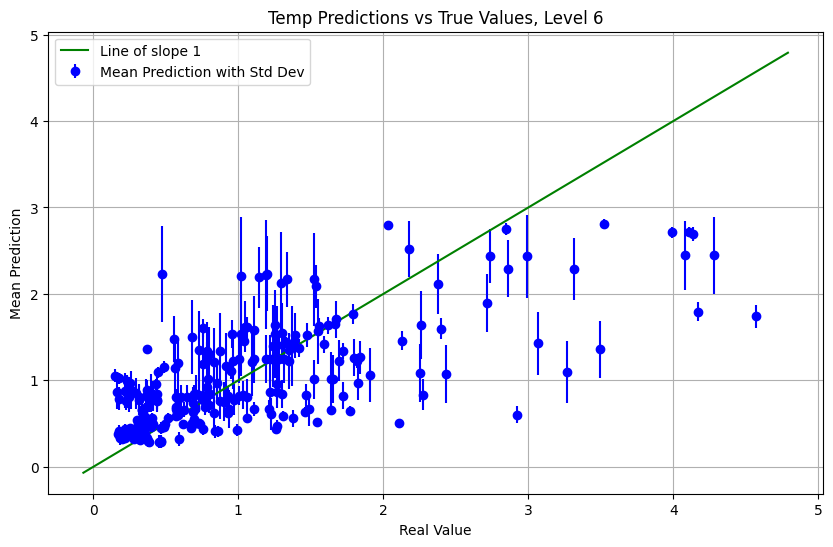

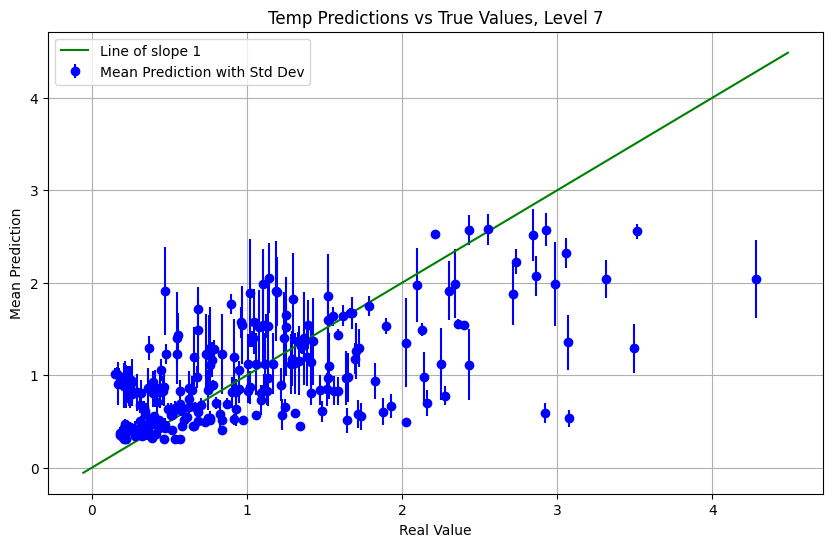

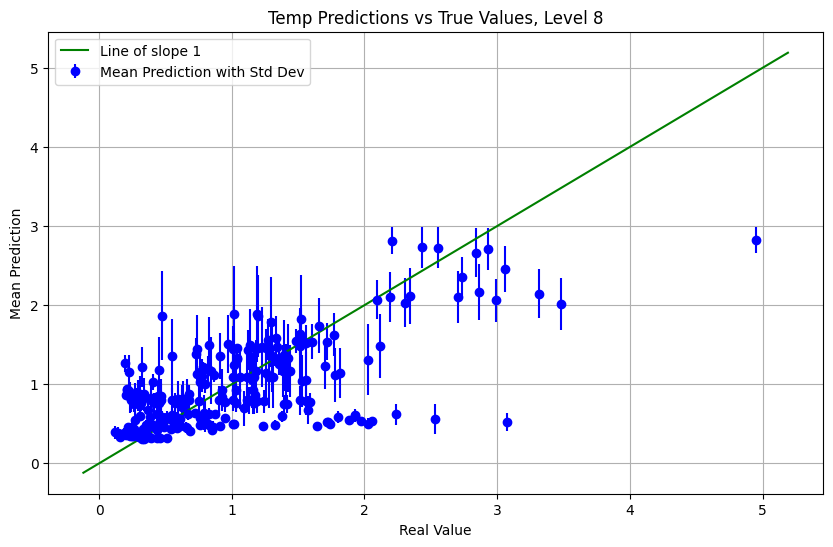

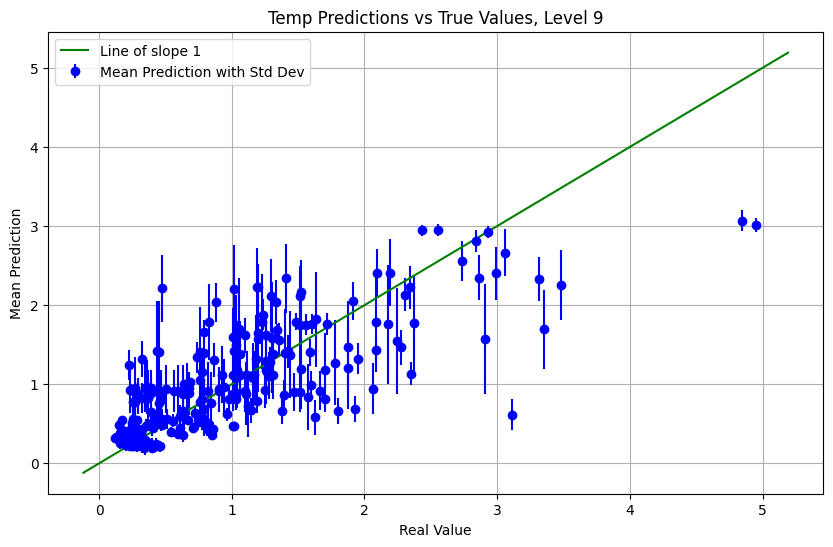

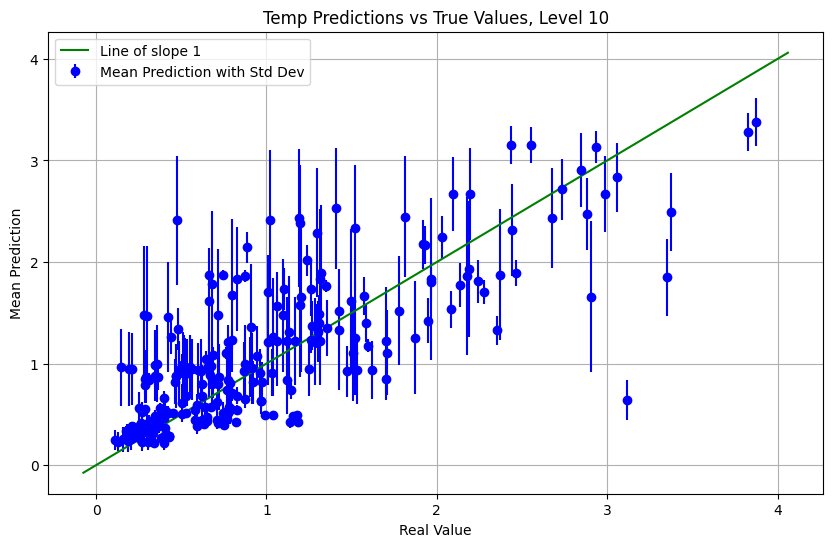

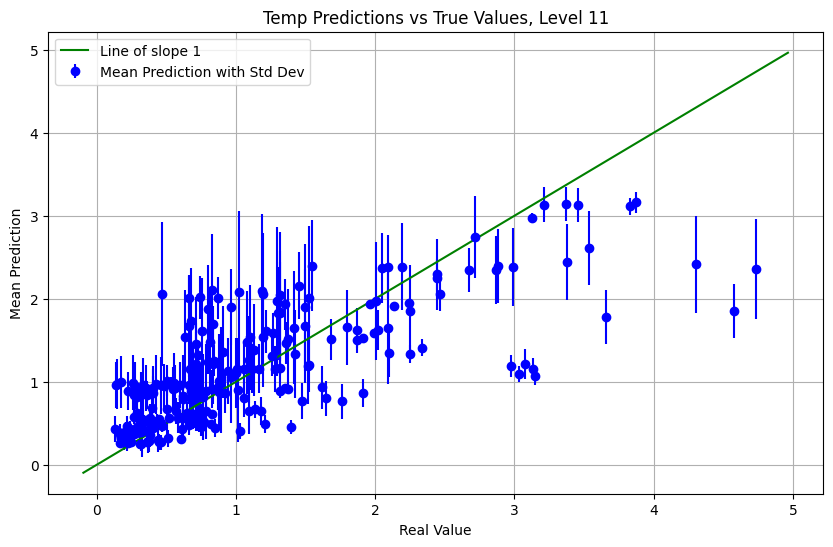

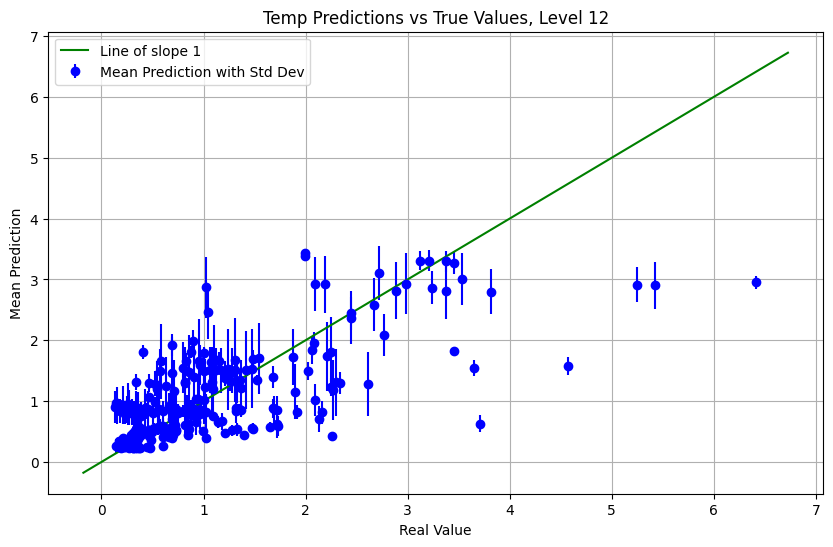

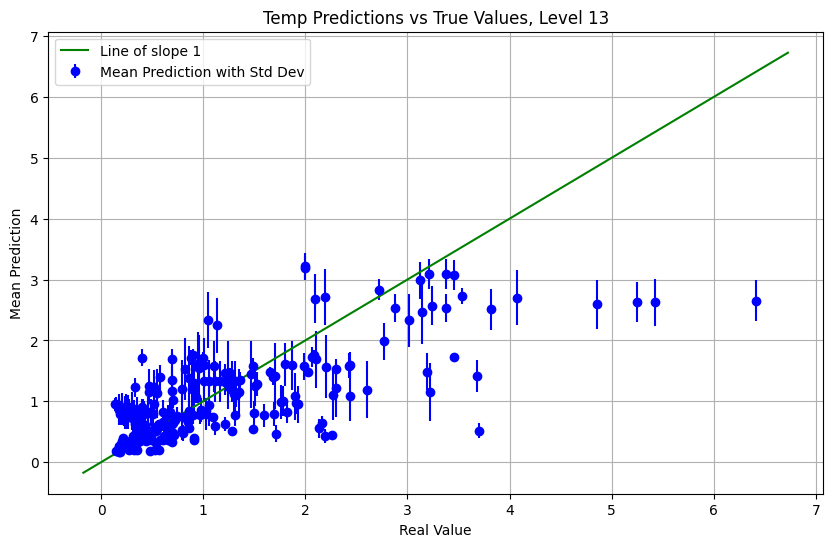

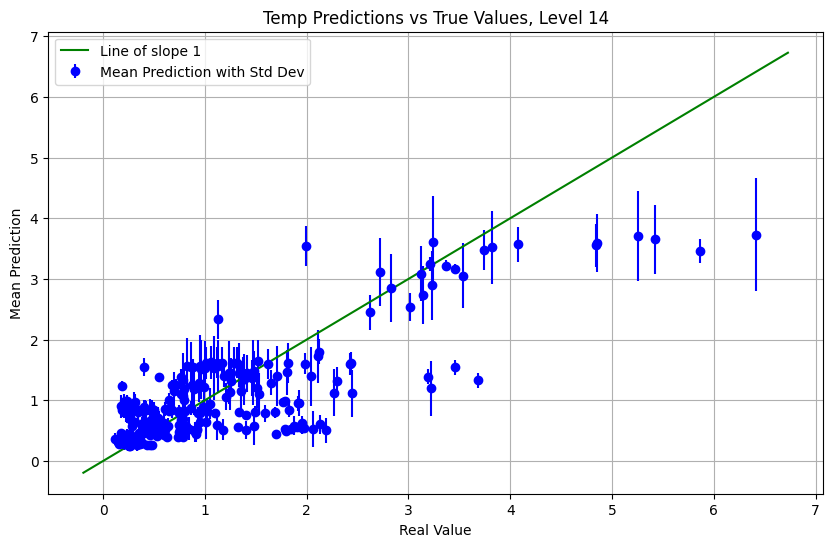

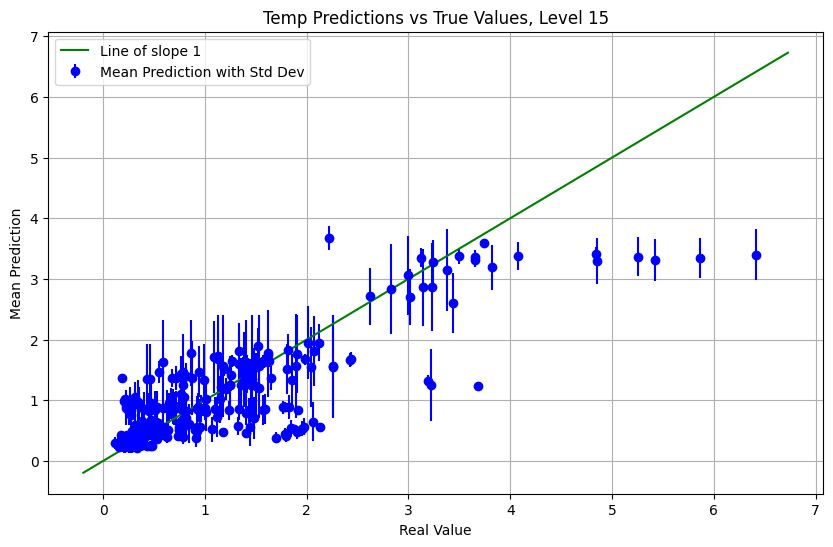

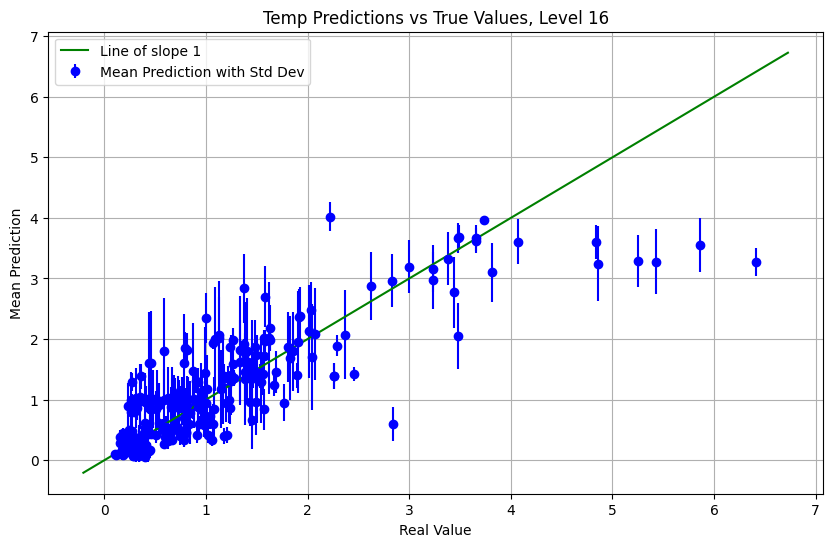

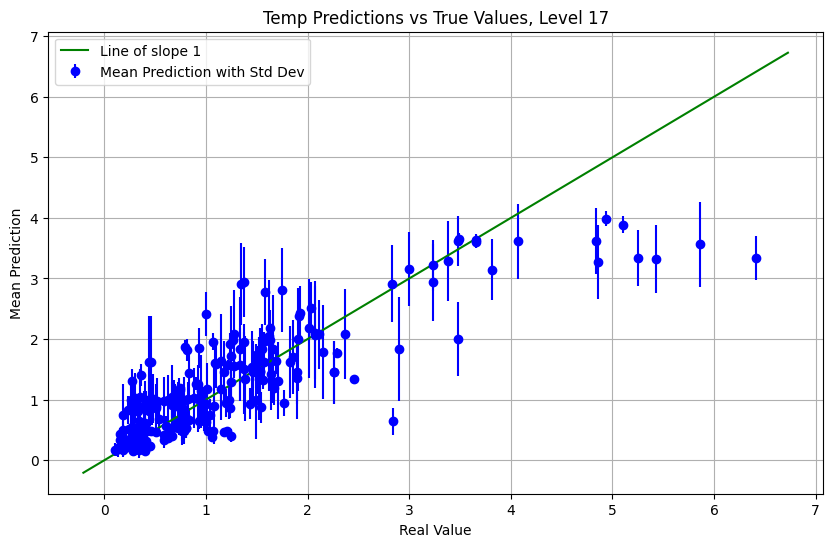

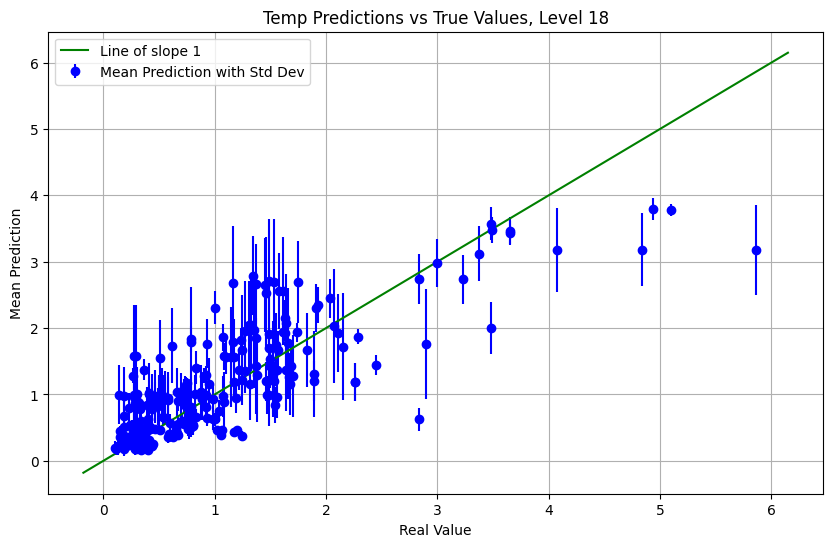

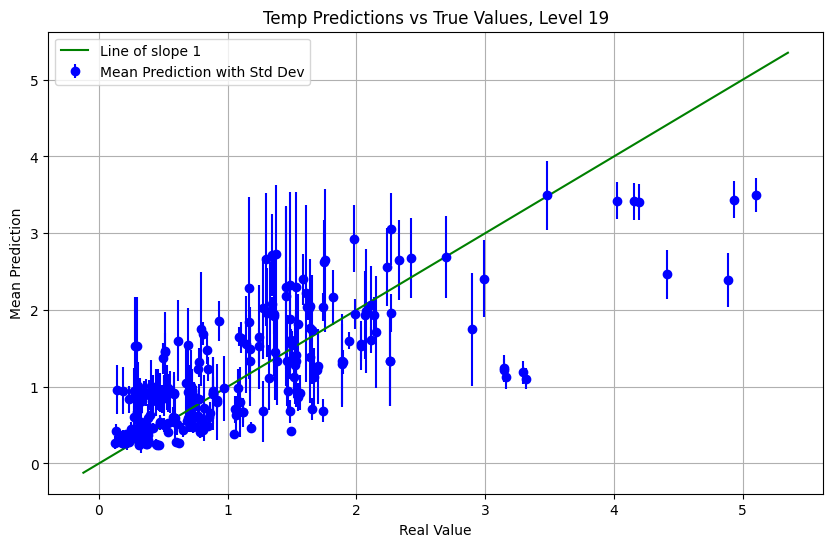

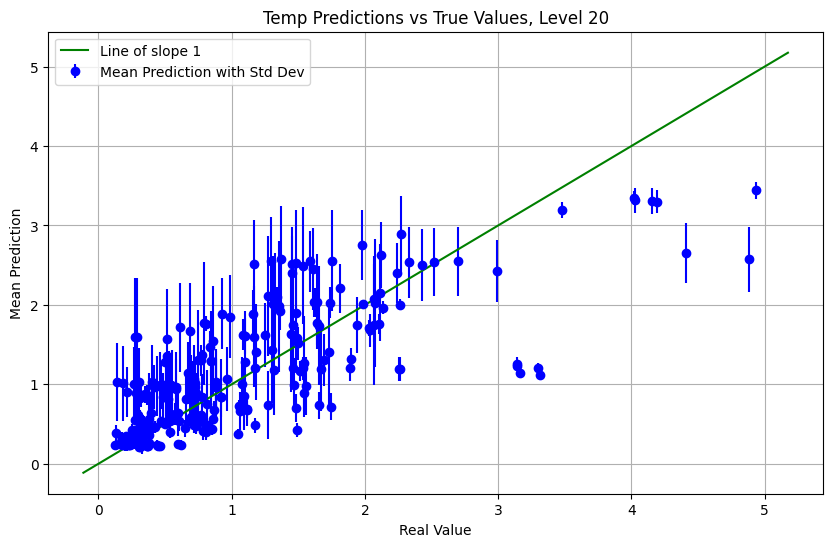

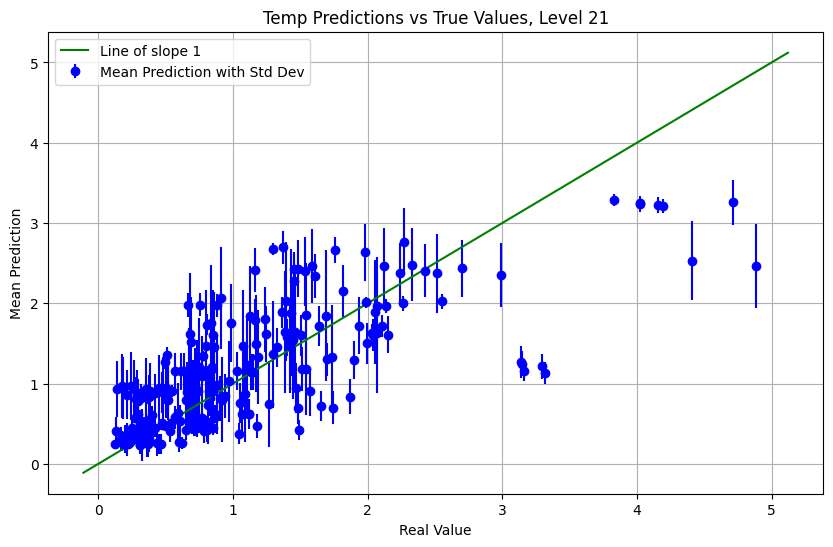

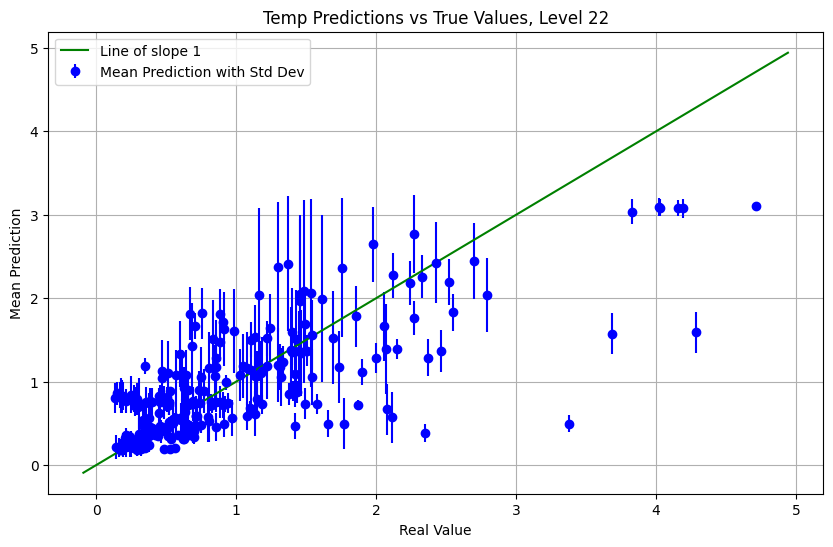

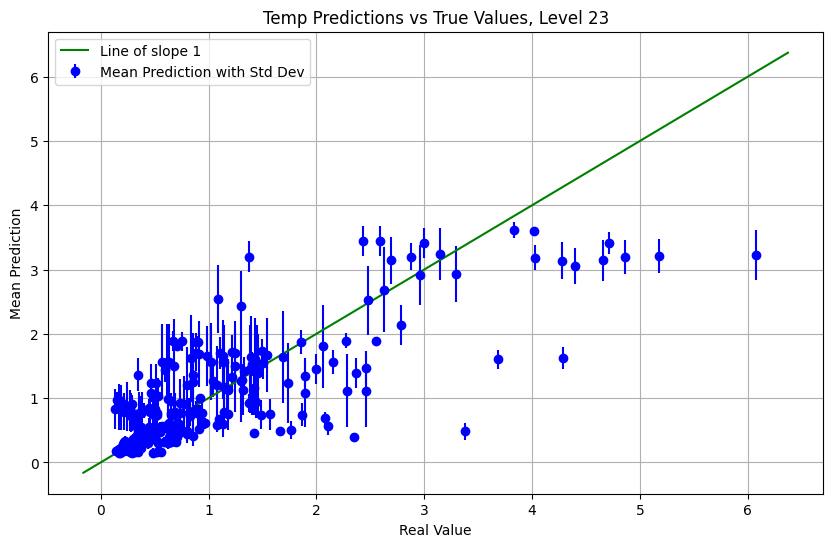

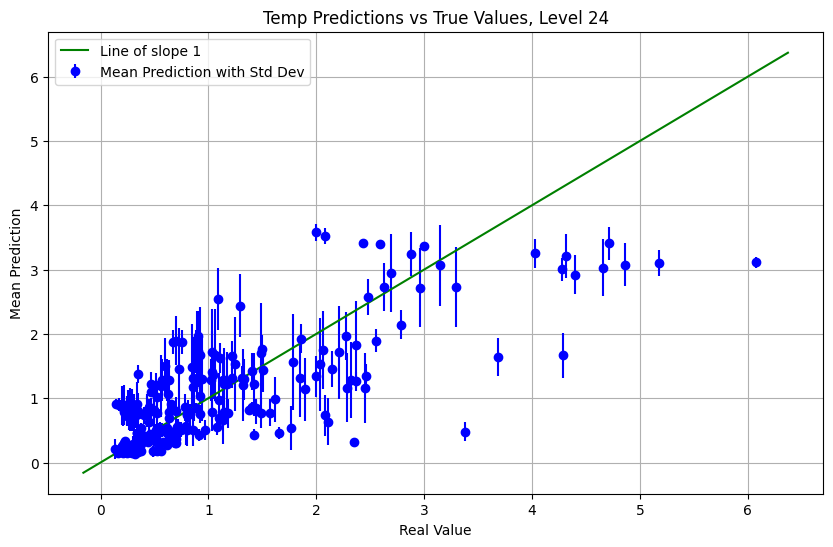

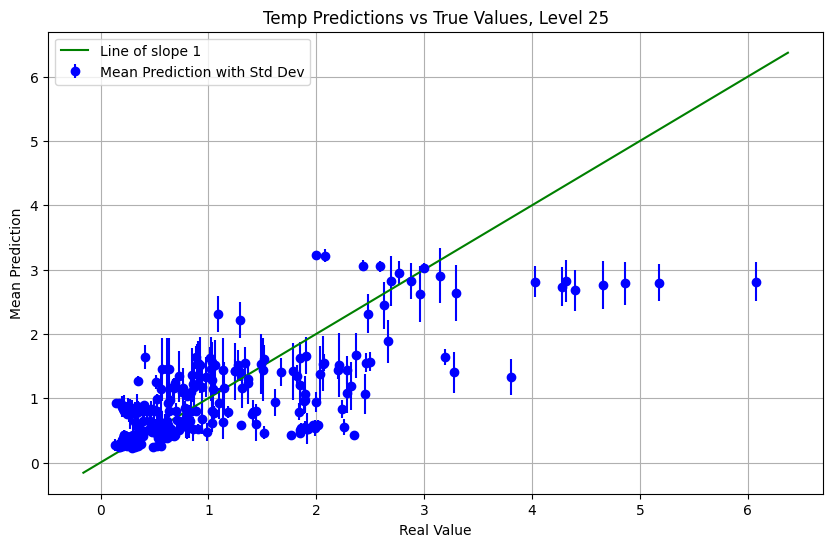

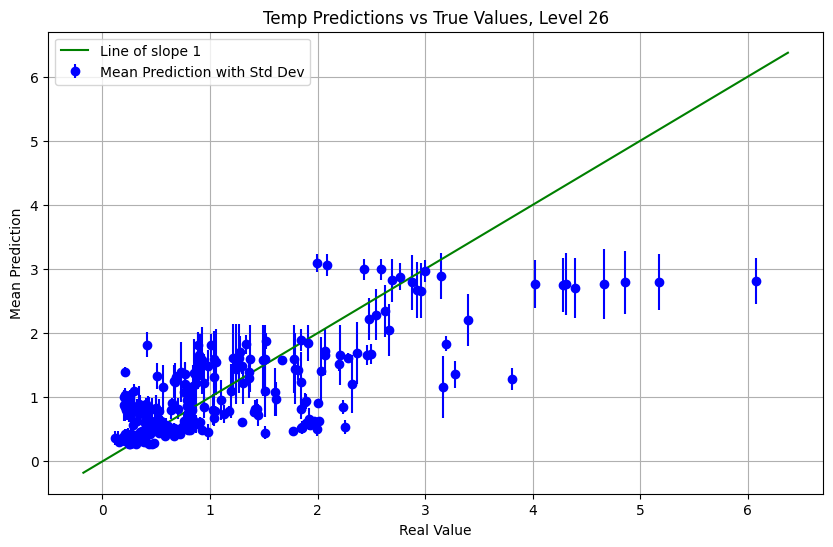

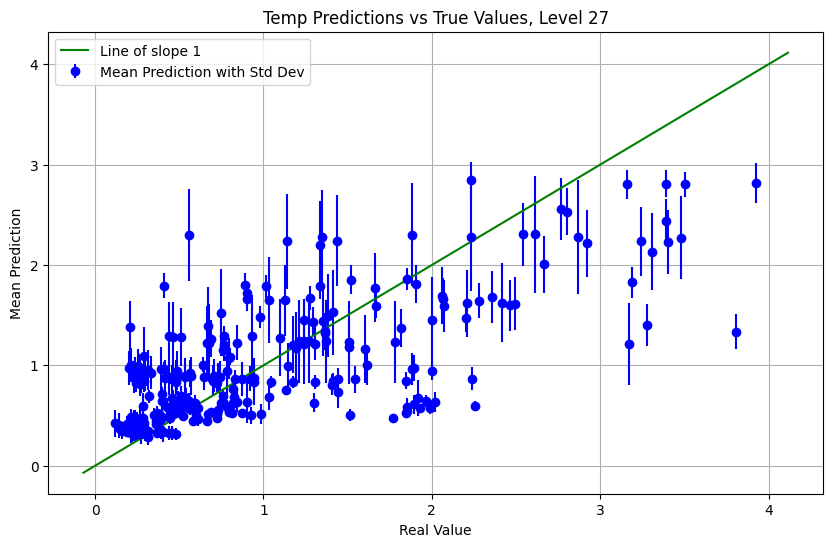

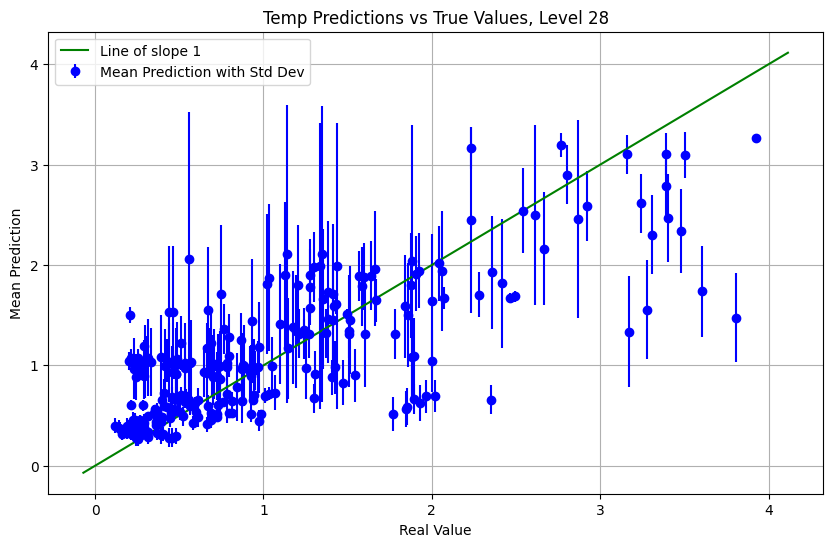

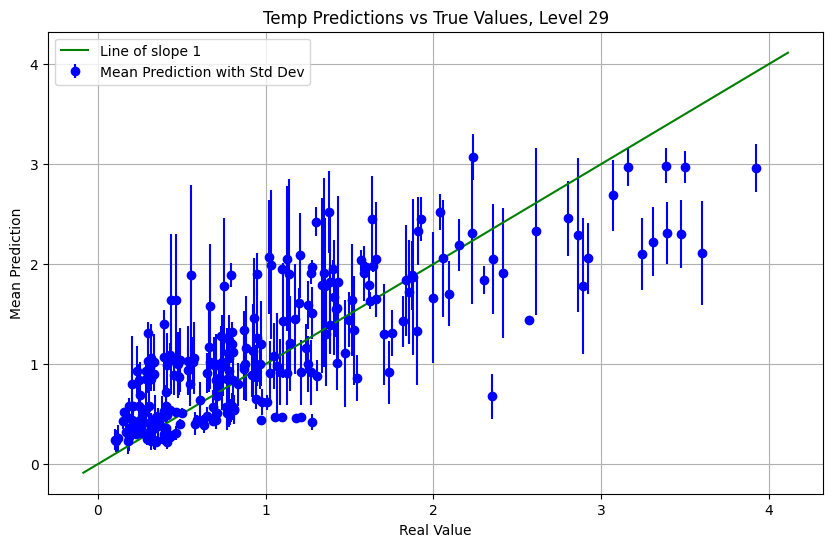

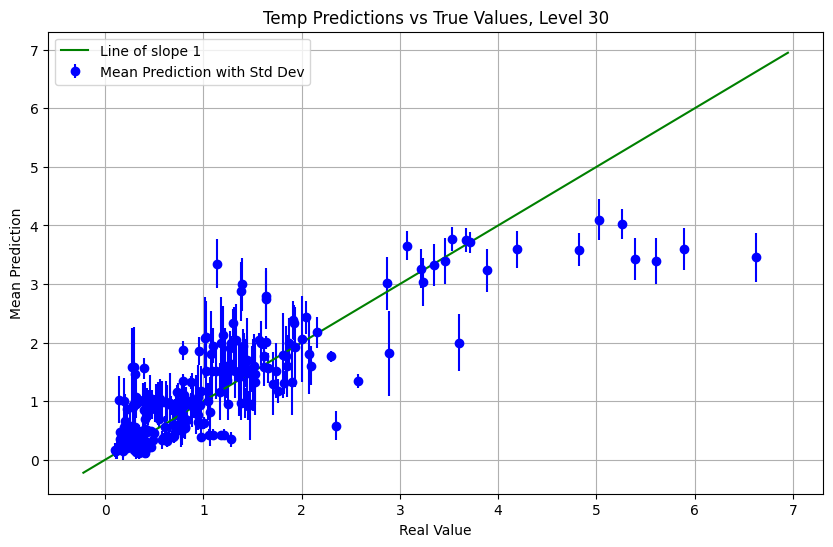

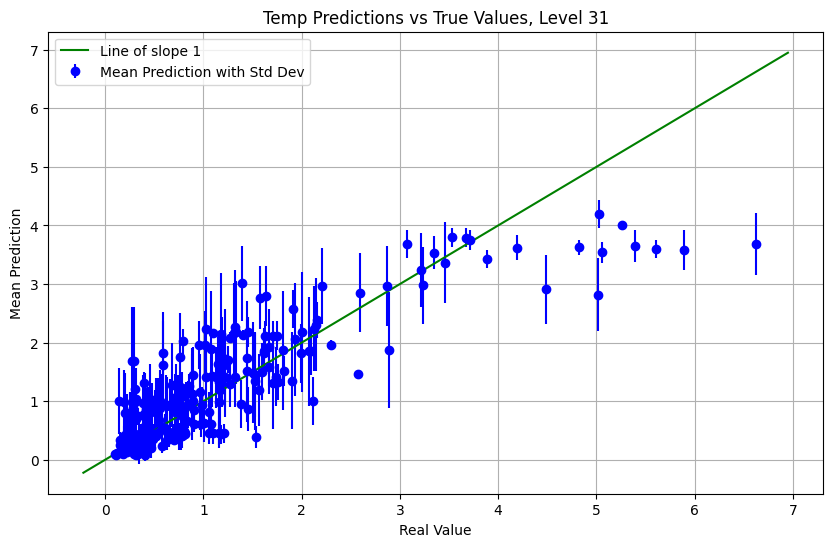

In [39]:
for i in range(32):
    plot_values = {}
    for k,v in model_preds.items():
        plot_values[k] = (slice_column(v[0], i), slice_column(v[1], i))
    plot_cell(plot_values, i, 0)

## Save Model

In [40]:
for i,m in models.items():
    try:
        script_model = torch.jit.script(m)
        script_model.save(f"./weights/no2dfields_net_{i}.pt")
        print(f"Model {i} saved successfully.")
    except Exception as e:
        print(f"Error saving model {i}: {e}")

Model 0 saved successfully.
Model 1 saved successfully.
Model 2 saved successfully.
